How data balancing methods affect model quality?

In [ ]:
import os
from pathlib import Path
from itertools import combinations
from math import pi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input


In [53]:
train_dir = Path('./data/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('./data/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path('./data/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

aug_dir = Path('./data/augmented/')
aug_filepaths = list(aug_dir.glob(r'**/*.jpg')) + list(aug_dir.glob(r'**/*.jpeg'))

data = train_filepaths + test_filepaths + val_filepaths

In [54]:
def paths_to_dataframe(path):
    labels = []
    for i in range(len(path)):
        labels.append(str(path[i]).split(os.sep)[-2])

    labels = pd.Series(labels, name='Label')
    path = pd.Series(path, name='Path').astype(str)

    df = pd.concat([path, labels], axis=1)

    df = df.sample(frac=1).reset_index(drop = True)

    return df
    
data_df = paths_to_dataframe(data)

In [55]:
data_df = data_df.sample(frac=1, random_state=42)
data_df.shape

(3450, 2)

In [56]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

X = np.array(data_df['Path'])
y = np.array(data_df['Label'])

In [57]:
def metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)

    classification_rep = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(classification_rep)

    classes = np.unique(y_test)
    class_accuracy = {}
    for cls in classes:
        indices = np.where(y_test == cls)[0]
        class_accuracy[cls] = accuracy_score(y_test[indices], np.array(y_pred)[indices])

    return accuracy, precision, recall, f1, class_accuracy

In [58]:
def sort_classes_by_gini_index(X_train, y_train):
    unique_labels = np.unique(y_train)
    gini_indices_per_class = {label: 0 for label in unique_labels}

    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)

    feature_importances = tree.feature_importances_
    sorted_features = np.argsort(feature_importances)[::-1]

    for label in unique_labels:
        indices = np.where(y_train == label)[0]
        gini_indices_per_class[label] = np.mean(feature_importances[sorted_features[:len(indices)]]) if len(indices) > 0 else 0

    sorted_labels = sorted(unique_labels, key=lambda label: gini_indices_per_class[label], reverse=True)
    return sorted_labels

In [59]:
def nested_dichotomy(X_train, y_train, X_test, balancer=None):
    unique_labels = sort_classes_by_gini_index(X_train, y_train)
    classifiers = []

    for i in unique_labels:
        y_binary = np.where(y_train == i, 1, 0)
        tree = DecisionTreeClassifier()

        if balancer != None:
            X_train_balanced, y_train_balanced = balancer.fit_resample(X_train, y_binary)
        else:
            X_train_balanced = X_train
            y_train_balanced = y_binary

        tree.fit(X_train_balanced, y_train_balanced)
        classifiers.append((tree, i))
        print(i)

    predictions = []
    for tree, positive_label in classifiers:
        binary_prediction = tree.predict(X_test)
        predictions.append(np.where(binary_prediction == 1, positive_label, None))

    results = [None for _ in range(len(X_test))]
    for i in range(len(predictions)):
        for j in range(len(X_test)):
            if predictions[i][j] is not None and results[j] == None:
                results[j] = unique_labels[i]

    for i in range(len(results)):
        if results[i] is None:
            results[i] = unique_labels[0]
        

    return results, predictions, classifiers

In [60]:
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

In [ ]:
vgg16_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
X_ext = np.array([extract_features(img_path, vgg16_model) for img_path in X])

In [ ]:
def experiment_loop():

    balancers = {
        "None": None,
        "RandomOverSampler": RandomOverSampler(random_state=42),
        "SMOTE": SMOTE(random_state=42),
        "RandomUnderSampler": RandomUnderSampler(random_state=42),
        "TomekLinks": TomekLinks(),
        "SMOTETomek": SMOTETomek(random_state=42)
    }
    
    scores = [[] for _ in range(k)]

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X_ext[train_index], X_ext[val_index]
        y_train, y_val = y[train_index], y[val_index]

        for balancer_name, balancer in balancers.items():
            print(balancer_name)
            results, pred, models = nested_dichotomy(X_train, y_train, X_val, balancer)
            accuracy, precision, recall, f1, class_accuracy = metrics(y_val, results)
            scores[fold].append((accuracy, precision, recall, f1, class_accuracy))

    return scores

scores = experiment_loop()


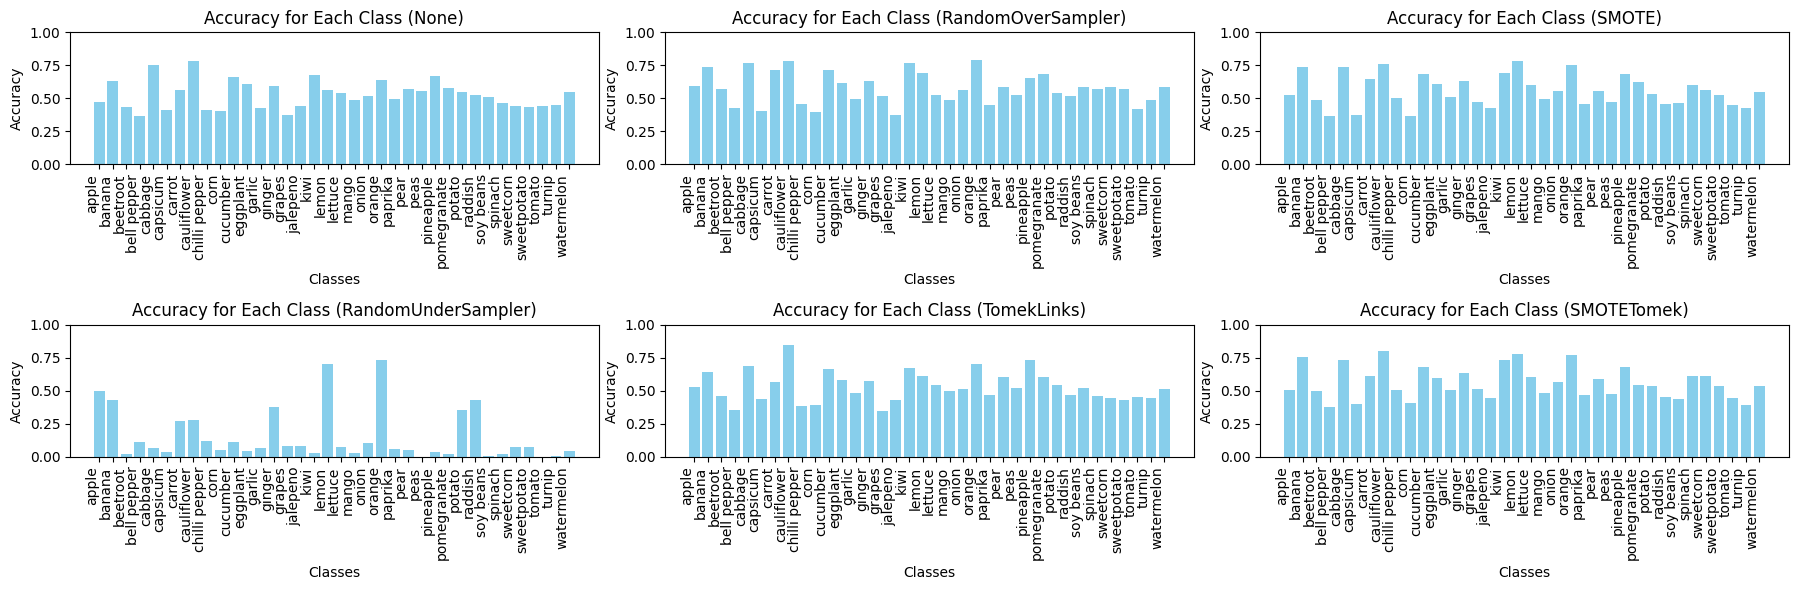

In [63]:
plt.figure(figsize=(18, 6))

balancer_names = ['None', 'RandomOverSampler', 'SMOTE', 'RandomUnderSampler', 'TomekLinks', 'SMOTETomek']
titles = ['Accuracy for Each Class (None)', 'Accuracy for Each Class (RandomOverSampler)', 
          'Accuracy for Each Class (SMOTE)', 'Accuracy for Each Class (RandomUnderSampler)', 
          'Accuracy for Each Class (TomekLinks)', 'Accuracy for Each Class (SMOTETomek)']

class_labels = set()
for i, balancer_name in enumerate(balancer_names, start=1):
    class_accuracy = {}
    for fold_scores in scores:
        for cls, acc in fold_scores[i-1][4].items():
            if cls not in class_accuracy:
                class_accuracy[cls] = []
                class_labels.add(cls)
            class_accuracy[cls].append(acc)

    avg_class_accuracy = {cls: np.mean(acc_list) for cls, acc_list in class_accuracy.items()}  # Calculate average accuracy for each class
    
    plt.subplot(2, 3, i)
    class_labels_list = sorted(class_labels)  # Convert set to sorted list
    plt.bar(class_labels_list, [avg_class_accuracy.get(cls, 0) for cls in class_labels_list], color='skyblue')
    plt.title(titles[i-1])
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=90, ha='right')
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

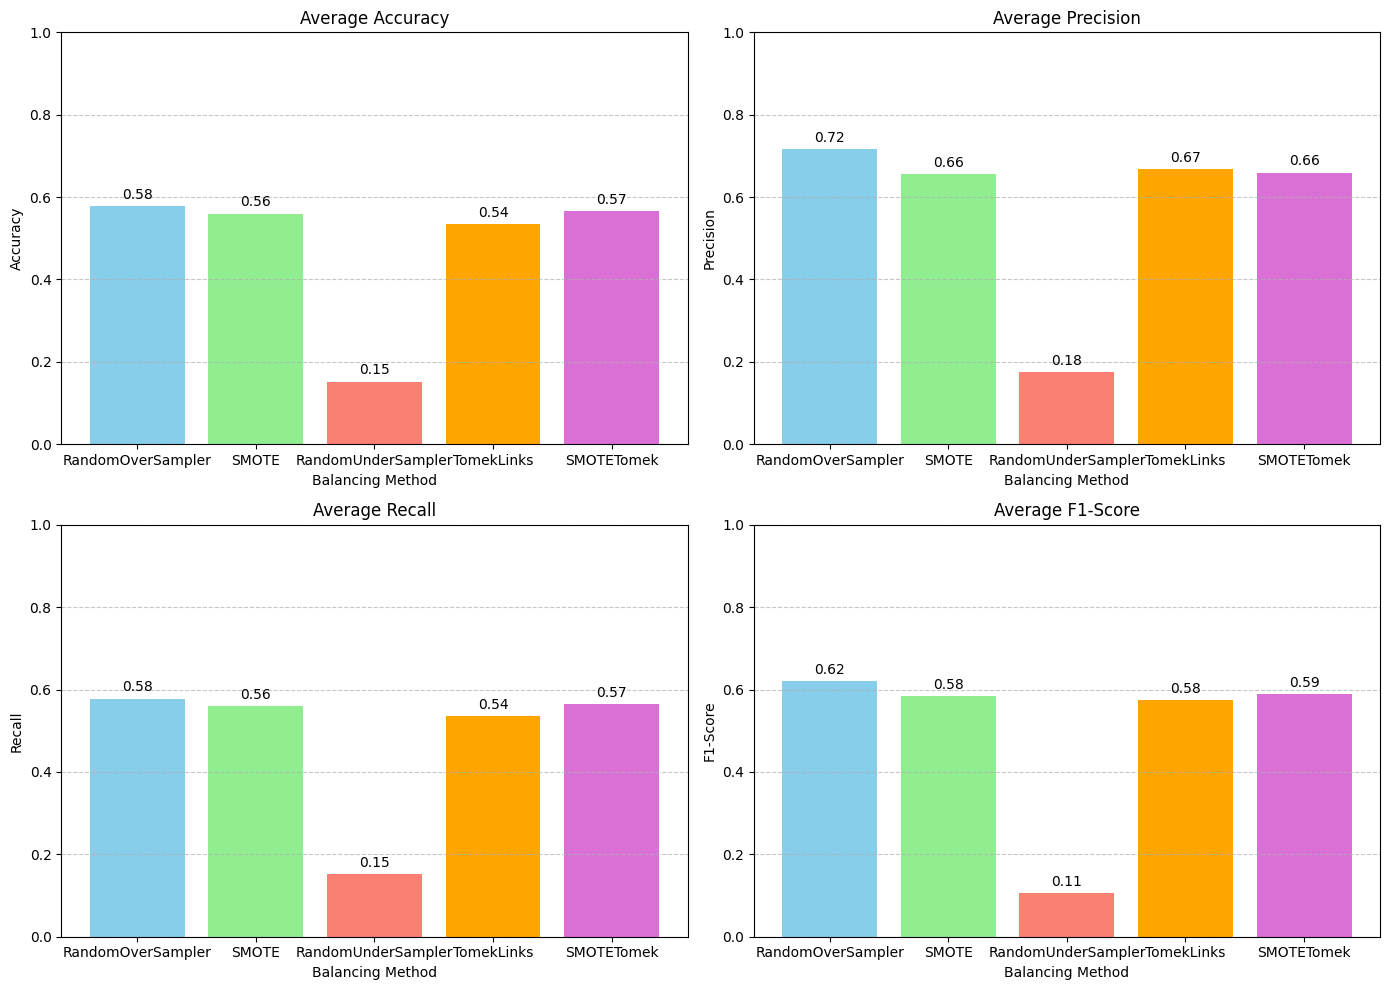

In [64]:
methods = ['RandomOverSampler', 'SMOTE', 'RandomUnderSampler', 'TomekLinks', 'SMOTETomek']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'orchid']

metrics_data = {}
for metric in metrics:
    metrics_data[metric] = []

for method in methods:
    for metric in metrics:
        metric_values = []
        for fold_scores in scores:
            method_idx = balancer_names.index(method)
            metric_values.append(fold_scores[method_idx][metrics.index(metric)])
        metrics_data[metric].append(np.mean(metric_values))

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics):
    ax = plt.subplot(2, 2, i+1)
    bars = plt.bar(methods, metrics_data[metric], color=colors)
    plt.title('Average ' + metric)
    plt.xlabel('Balancing Method')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [65]:
df = pd.DataFrame(metrics_data, index=methods)
print("Metrics Data:")
print(df)

Metrics Data:
                    Accuracy  Precision    Recall  F1-Score
RandomOverSampler   0.577971   0.716607  0.577971  0.619816
SMOTE               0.560000   0.656804  0.560000  0.584093
RandomUnderSampler  0.151884   0.175275  0.151884  0.105518
TomekLinks          0.535072   0.668169  0.535072  0.575018
SMOTETomek          0.565797   0.659660  0.565797  0.588802


In [66]:
def corrected_t_test(accuracies_1, accuracies_2, corr=0.1):
    """
    Performs the corrected t-test for cross-validation results.

    Parameters:
    accuracies_1 (list or np.array): A list or array of accuracy scores from cross-validation for technique 1.
    accuracies_2 (list or np.array): A list or array of accuracy scores from cross-validation for technique 2.
    corr (float, optional): The correlation between successive folds. If None, it will be estimated empirically.

    Returns:
    float: The t-statistic value.
    float: The p-value corresponding to the t-statistic.
    """
    m1 = len(accuracies_1)
    m2 = len(accuracies_2)
    mean_accuracy_1 = np.mean(accuracies_1)
    mean_accuracy_2 = np.mean(accuracies_2)
    variance_1 = np.var(accuracies_1, ddof=1)
    variance_2 = np.var(accuracies_2, ddof=1)
  
    
    corrected_variance_1 = variance_1 / (m1 * (1 - corr))
    corrected_variance_2 = variance_2 / (m2 * (1 - corr))
    standard_error = np.sqrt(corrected_variance_1 / m1 + corrected_variance_2 / m2)
    
    t_statistic = (mean_accuracy_1 - mean_accuracy_2) / standard_error
    p_value = stats.t.sf(np.abs(t_statistic), df=min(m1, m2) - 1) * 2  # two-tailed p-value
    
    return t_statistic, p_value

In [67]:
methods = ['RandomOverSampler', 'SMOTE', 'RandomUnderSampler', 'TomekLinks', 'SMOTETomek']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

pairs = combinations(methods, 2)

for pair in pairs:
    method_1, method_2 = pair
    
    accuracies_1 = []
    accuracies_2 = []
    
    method_1_idx = balancer_names.index(method_1)
    method_2_idx = balancer_names.index(method_2)
    
    for fold_scores in scores:
        accuracies_1.append(fold_scores[method_1_idx][0])  # Accuracy scores
        accuracies_2.append(fold_scores[method_2_idx][0])  # Accuracy scores
    
    t_statistic, p_value = corrected_t_test(accuracies_1, accuracies_2)
    
    if t_statistic > 0:
        comparison = f"{method_1} is better than {method_2}"
    elif t_statistic < 0:
        comparison = f"{method_2} is better than {method_1}"
    else:
        comparison = f"There is no significant difference between {method_1} and {method_2}"
    
    significance = "significant" if p_value < 0.05 else "not significant"
    
    print(f'{method_1} vs. {method_2}:')
    print(f'T-statistic: {t_statistic}')
    print(f'P-value: {p_value}')
    print(f'Result: {comparison} (p-value {significance})')


RandomOverSampler vs. SMOTE:
T-statistic: 4.6355365123968415
P-value: 0.009766599573729119
Result: RandomOverSampler is better than SMOTE (p-value significant)
RandomOverSampler vs. RandomUnderSampler:
T-statistic: 116.8647662707013
P-value: 3.215177142895849e-08
Result: RandomOverSampler is better than RandomUnderSampler (p-value significant)
RandomOverSampler vs. TomekLinks:
T-statistic: 15.061668400471259
P-value: 0.0001132407403168925
Result: RandomOverSampler is better than TomekLinks (p-value significant)
RandomOverSampler vs. SMOTETomek:
T-statistic: 3.6449081810843413
P-value: 0.02186958102633644
Result: RandomOverSampler is better than SMOTETomek (p-value significant)
SMOTE vs. RandomUnderSampler:
T-statistic: 99.56063479106587
P-value: 6.102511243429202e-08
Result: SMOTE is better than RandomUnderSampler (p-value significant)
SMOTE vs. TomekLinks:
T-statistic: 7.311980596320216
P-value: 0.0018608414744563245
Result: SMOTE is better than TomekLinks (p-value significant)
SMOTE 

/var/folders/kb/21stffp561n7vlhn9h_r55zc0000gn/T/ipykernel_67764/2266385342.py:34: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1)


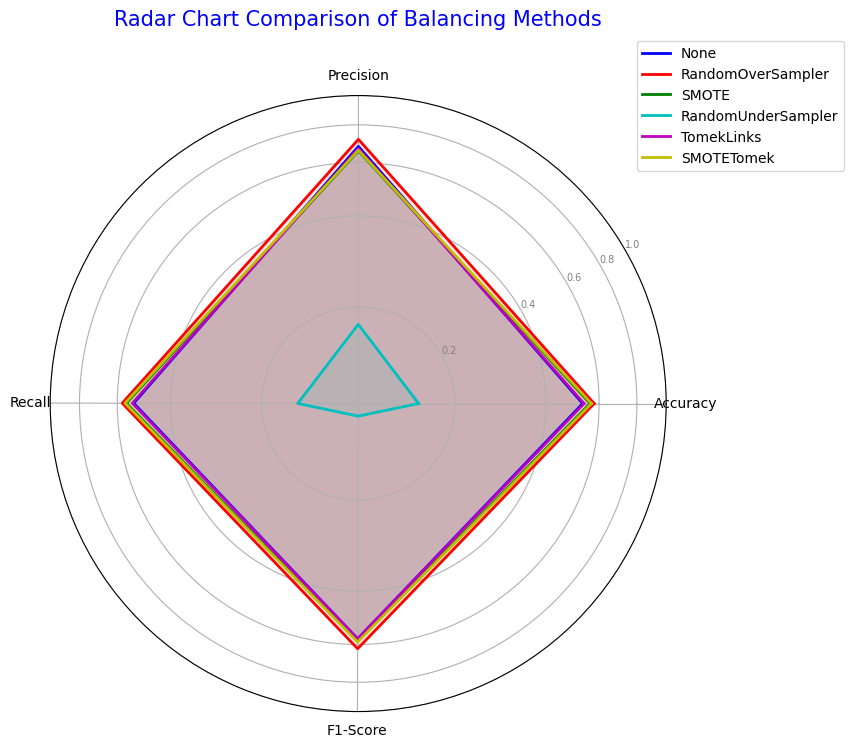

In [68]:
def create_radar_chart(scores, methods):
    categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    N = len(categories)
    pi = 3.14
    # Kąt dla każdej osi w wykresie radarowym
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Inicjalizacja wykresu
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Kolory dla każdej metody balansowania
    colors = ['b', 'r', 'g', 'c', 'm', 'y']
    
    for i, method_scores in enumerate(scores):
        method_values = []
        for category_scores in method_scores:
            if category_scores:
                method_values.append(np.mean(category_scores))
            else:
                method_values.append(0)  # Jeśli brak danych, ustaw wartość na 0
        values = method_values
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=methods[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=0.1)
    
    # Dodanie etykiet osi
    plt.xticks(angles[:-1], categories)
    
    # Ustawienia osi y
    ax.set_rscale('log')
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=7)
    plt.ylim(0, 1)
    
    plt.title('Radar Chart Comparison of Balancing Methods', size=15, color='blue', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Użyj funkcji create_radar_chart, podając wyniki z scores i nazwy metod z balancer_names
create_radar_chart([[[score[i][j] for score in scores if score[i]] for j in range(4)] for i in range(len(balancer_names))], balancer_names)
